In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Convolution2D,Flatten,Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data = np.load('Preprocessed_data.npy')
imgs = data[0]
steering = data[1]

#splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(imgs, steering, test_size= 0.2)

In [3]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(18271,)
(4568,)
(18271,)
(4568,)


### Image Processing, Batch generator and Image Augmentation

In [37]:
#refer to Image Processing notebook for more details
#about this cell

#Now combining the brigtness control and
#image fliping in one function
#this function of augmentation is also going to
#be a batch generator

def batch_generator(imgs,steering,batch_size):
    
    #infinite loop
    while True:
        
        X=[]
        y=[]
        
        #running the whole process for each batch of images
        for i in range(batch_size):
        
            #getting random image index from imgs
            index = np.random.randint(0,len(imgs)-1)
            #passing and reading the random image index
            img = cv.imread(imgs[index])
            
            #converting the image to yuv as discussed above
            # img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
            #or img = bgr2yuv(img)
            
            #cropping image as discussed above
            img = img[60:135,:,:]
            #or img = crop_img(img)
            
            #adjusting for the model's first layer  with size (66,200,3) as input
            img = cv.resize(img, (200,66))
            
            #instead of going for each image brigntness control
            #we will go for only random images
            if (np.random.rand()>0.5):
                #brightness control
                brigtness_cont = np.random.randint(1,4)
                img = (img/ brigtness_cont).astype(np.uint8)

            #similarly for fliping the image
            # if (np.random.rand()>0.5):
            #     #image fliping
            #     img = cv.flip(img,1)
            #     steering_angle = -float(steering[index])
            # else:
            #     steering_angle = float(steering[index])

            X.append(img)
            # y.append(steering_angle)
            y.append(float(steering[index]))
        
        #converting the image 
        # and steering_angle processed into the numpy array
        X = np.array(X)
        y = np.array(y)
        
        
        #Yield is a keyword in Python that is used to return from a function 
        #without destroying the states of its local variable and
        #when the function is called, the execution starts from the last yield statement. 
        #Any function that contains a yield keyword is termed a generator. 
        #Hence, yield is what makes a generator. 
        yield X,y

In [38]:
model = Sequential()

model.add(Convolution2D(24, (5,5), strides = (2,2), input_shape = (66,200,3), activation = 'elu'))
model.add(Convolution2D(36, (5,5), strides =(2,2), activation = 'elu'))
model.add(Convolution2D(48, (5,5), strides =(2,2), activation = 'elu'))

model.add(Convolution2D(64, (5,5), activation = 'elu'))
model.add(Convolution2D(64, (3,3), activation = 'elu'))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(1, activation = 'elu'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_15 (Dense)            (None, 100)              

In [40]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('min_loss_model_50.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

In [ ]:
model.compile(loss = "mean_squared_error", optimizer = Adam(lr = ))

In [41]:
#taking len(X_train)//64 = 36 images for steps for each epoch 
history = model.fit(batch_generator(X_train,y_train,64), steps_per_epoch = 2000, epochs = 50, callbacks = [es,mc],
                    validation_data = batch_generator(X_test,y_test,64), validation_steps = 200)

Epoch 1/50
1999/2000 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.1588
Epoch 1: val_loss improved from inf to 0.04065, saving model to min_loss_model_50.h5
2000/2000 [==============================] - 543s 270ms/step - loss: 0.3168 - accuracy: 0.1588 - val_loss: 0.0406 - val_accuracy: 0.2262
Epoch 2/50
1999/2000 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.2261
Epoch 2: val_loss did not improve from 0.04065
2000/2000 [==============================] - 108s 54ms/step - loss: 0.0410 - accuracy: 0.2261 - val_loss: 0.0407 - val_accuracy: 0.2163
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.2290
Epoch 3: val_loss improved from 0.04065 to 0.03914, saving model to min_loss_model_50.h5
2000/2000 [==============================] - 105s 53ms/step - loss: 0.0408 - accuracy: 0.2290 - val_loss: 0.0391 - val_accuracy: 0.2266
Epoch 4/50
1999/2000 [============================>.] - ETA: 0s - loss: 0.04

In [29]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.2232031226158142, 0.2109375, 0.22093750536441803, 0.2185937464237213, 0.22132812440395355, 0.21968750655651093, 0.22624999284744263, 0.22304686903953552, 0.22289063036441803, 0.22187499701976776, 0.22273437678813934, 0.22203125059604645, 0.22414062917232513, 0.21968750655651093, 0.21687500178813934, 0.2160937488079071, 0.2219531238079071, 0.21257811784744263]
The training accuracy is : [0.22560937702655792, 0.22735156118869781, 0.22939062118530273, 0.22846874594688416, 0.22957031428813934, 0.22865624725818634, 0.22835156321525574, 0.22724218666553497, 0.2271406203508377, 0.2272343784570694, 0.22688281536102295, 0.22697655856609344, 0.22925780713558197, 0.22975781559944153, 0.22977343201637268, 0.22778905928134918, 0.22810937464237213, 0.22951562702655792]
The validation loss is : [0.03956609591841698, 0.04136066138744354, 0.040231868624687195, 0.04072697088122368, 0.040634457021951675, 0.040267787873744965, 0.039967332035303116, 0.039150308817625046, 0.0

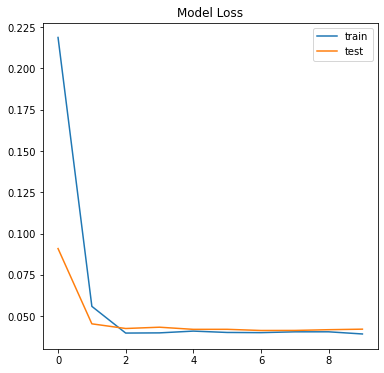

In [30]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Model Loss")
plt.show()

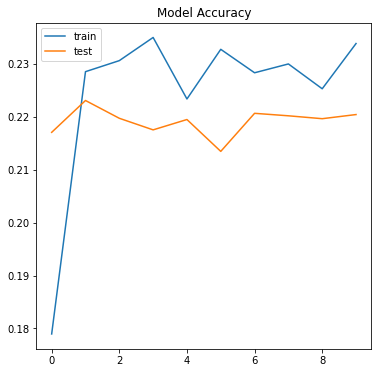

In [31]:
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title("Model Accuracy")
plt.show()

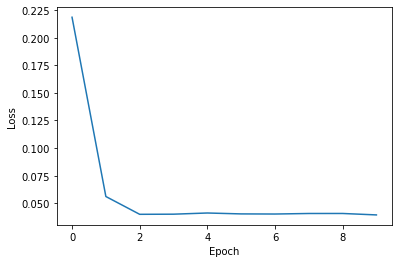

In [21]:
plt.plot(history.history['loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

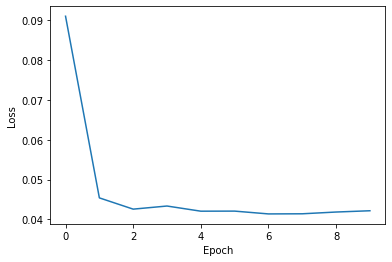

In [22]:
plt.plot(history.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

In [23]:
model.save('Model.h5')